# PROJET IF29

## Première étape : preprocessing

Afin de lancer le code suivant, le format de répertoire suivant doit être présent :
Dans le répertoire du fichier actuel doit se trouver un répertoire nommé "données", dans lequel on trouve:
* un répertoire "raw" (dans lequel se trouvent les données brute fournit par l'énoncé).
* un répertoire "cleaned", initialement vide, qui sera remplit lors du traitement des données


Les importations nécessaire :

In [52]:
import os
import time
import json
import csv
from datetime import datetime
import cProfile
import pstats
import functools
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


**Définition des données**

On utilise une définition des données orienté-objet pour avoir une sélection des caractéristiques modulaire.
On définit donc ici une classe Account représentant un compte twitter

Il possède les caractéristiques classiques d'un compte :
- identifiant
- date de création
- longueur de la biographie
- nombre de followers
- nombre de "friends"

ainsi que des caractéristiques moyennes sur les tweets :
- nombre de tweet trouvés
- nombre moyen de #, @ et url

Un Account possède trois méthodes : création à partir d'un tweet (constructeur), mise à jour au vu d'un autre tweet (update) et toCSV qui permet de transmettre les caractéristiques importantes, sous le bon format.


In [2]:
class Account:
    def __init__(self,tweet):
        self.creation_date = (datetime.now()-datetime.strptime(tweet['user']['created_at'],"%a %b %d %H:%M:%S +0000 %Y")).total_seconds()/(60*60*24)
        self.verified = tweet['user']['verified']
        try:
            self.bio_length = len(tweet['user']['description'])
        except:
            self.bio_length = 0
        self.id = tweet['user']['id']

        self.tweet_count = 1
        self.follow_count = tweet['user']['friends_count']
        self.followers_count = tweet['user']['followers_count']
        self.tweet_length = len(tweet['text'])
        
        self.url_by_tweet = tweet['text'].count("http")
        self.hashtag_by_tweet = tweet['text'].count('#')
        self.reference_by_tweet = tweet['text'].count("@")


    def update(self,tweet):
        self.tweet_count += 1
        self.follow_count += tweet['user']['friends_count']
        self.followers_count += tweet['user']['followers_count']
        self.tweet_length += len(tweet['text'])
        self.url_by_tweet += tweet['text'].count("http")
        self.hashtag_by_tweet += tweet['text'].count('#')
        self.reference_by_tweet = tweet['text'].count("@")


    def toCSV(self):
        self.follow_count /= self.tweet_count
        self.followers_count /= self.tweet_count
        self.tweet_length /= self.tweet_count
        self.url_by_tweet /= self.tweet_count
        self.reference_by_tweet /= self.tweet_count
        self.hashtag_by_tweet /= self.tweet_count
        return self.id,self.tweet_count,self.follow_count,self.followers_count,self.tweet_length,self.url_by_tweet,self.reference_by_tweet,self.hashtag_by_tweet,self.creation_date

**Traitement**

La partie suivante est la partie de traitement des données.
Chaque tweet est passé en revue et ajouté au compte correspondant.

La sauvegarde puis l'écriture des comptes se fait par paquet (batch) pour ne pas remplir la mémoire.

On utilise un profiler pour observer le temps de chaque étape, dans un soucis d'optimisation.

In [5]:
size=100 #la quantité de fichiers raw traités.
batch=10 #la quantité de fichier raw chargés ensemble.

def main(size=2285,batch=10):
    start_time = time.time()
    accounts = {}
    tweetcount=0
    for index in tqdm(range(size)):
        with open('données/raw/raw{}.json'.format(str(index)),encoding='UTF-8') as file:
            for tweet in (json.loads(line) for line in file):
                tweetcount+=1
                name = tweet['user']['name']
                if name not in accounts:
                    accounts[name] = Account(tweet)
                else:
                    accounts[name].update(tweet)
        if (index+1)%batch==0:
            with open('données/cleaned/clean{}.csv'.format(str(index//batch)),'w',encoding='UTF-8',newline="") as cleanfile:
                writer = csv.writer(cleanfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL).writerow
                for account in accounts.values():
                        writer(account.toCSV())
                        del account
            accounts = {}
    print("--- %s seconds ---" % (time.time() - start_time))

def profiler(func):
    cProfile.run(func,'{}.profile'.format(func))
    stats = pstats.Stats('{}.profile'.format(func))
    stats.strip_dirs().sort_stats('time').print_stats()
    
profiler('main(size={},batch={})'.format(size,batch))

100%|██████████| 100/100 [00:26<00:00,  3.41it/s]


--- 26.761297464370728 seconds ---
Wed Jun 23 18:51:46 2021    main(size=100,batch=10).profile

         8442865 function calls (8442864 primitive calls) in 26.777 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   199999   12.769    0.000   12.769    0.000 decoder.py:343(raw_decode)
   200099    4.220    0.000   18.982    0.000 <ipython-input-5-b8869c45e0a8>:10(<genexpr>)
        1    2.420    2.420   26.777   26.777 <ipython-input-5-b8869c45e0a8>:4(main)
   158376    1.600    0.000    3.071    0.000 _strptime.py:318(_strptime)
   158638    0.837    0.000    0.837    0.000 {built-in method _codecs.utf_8_decode}
   158376    0.580    0.000    4.485    0.000 <ipython-input-2-a54e90a70aa0>:2(__init__)
   558374    0.566    0.000    0.566    0.000 {method 'match' of 're.Pattern' objects}
   158376    0.486    0.000    0.486    0.000 {method 'writerow' of '_csv.writer' objects}
   199999    0.319    0.000   13.429    0.000 deco

        1    0.000    0.000    0.000    0.000 _tqdm.py:481(_get_free_pos)
        2    0.000    0.000    0.001    0.000 _tqdm.py:1154(close)
        1    0.000    0.000    0.000    0.000 _tqdm.py:488(_decr_instances)
        4    0.000    0.000    0.000    0.000 _weakrefset.py:58(__iter__)
        1    0.000    0.000    0.001    0.001 _monitor.py:32(__init__)
       10    0.000    0.000    0.000    0.000 codecs.py:186(__init__)
        1    0.000    0.000    0.000    0.000 threading.py:758(__init__)
        3    0.000    0.000    0.000    0.000 _weakrefset.py:26(__exit__)
        1    0.000    0.000    0.001    0.001 threading.py:829(start)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1009(_handle_fromlist)
        2    0.000    0.000    0.000    0.000 _weakrefset.py:81(add)
        1    0.000    0.000    0.000    0.000 _utils.py:183(_supports_unicode)
        1    0.000    0.000    0.000    0.000 threading.py:1000(join)
        3    0.000    0.000    0.0

**ouverture et standardisation**

In [6]:
frames = [pd.read_csv("données/cleaned/"+file,sep=',') for file in os.listdir("données/cleaned")]

for frame in frames:
    frame.columns = ["id","tweet count","follow count","followers count","tweet length","url","reference","hashtag","age"]
    
df = pd.concat(frames)

df_id = df.iloc[:,0]
df = df.drop(df.columns[0],axis=1)

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

Affichage 3d des données

Pour la représentation en 3d, on reconstruit trois indicateurs : aggressivité, visibilité et danger.

<IPython.core.display.Javascript object>


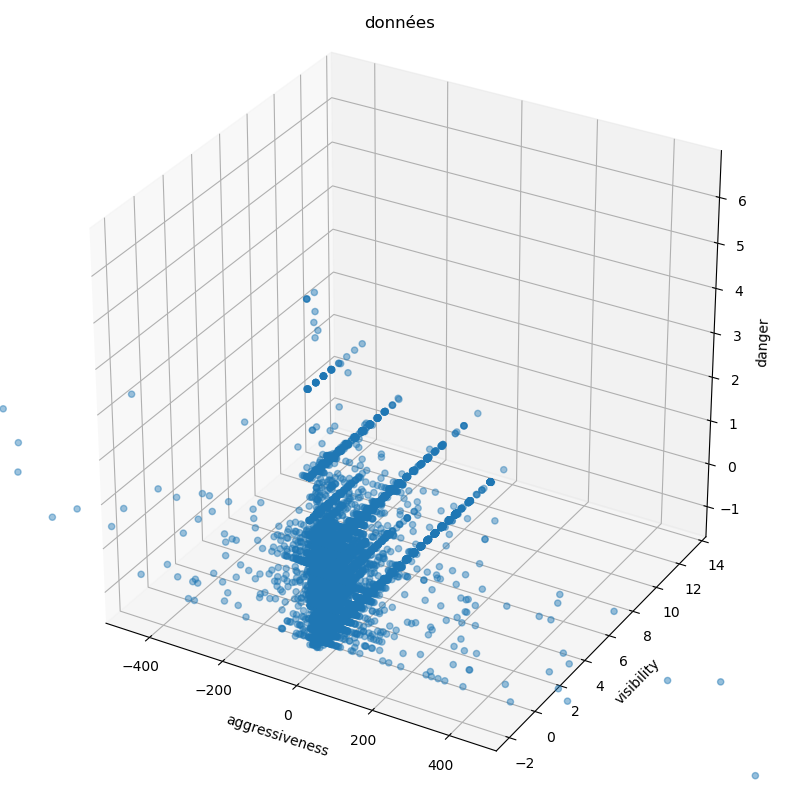

In [50]:
def plot3d(data,titre,labels=None,cmap="bwr"):
    fig = plt.figure()
    fig.suptitle(titre)
    ax = Axes3D(fig)
    fig.set_size_inches(8,8)
    if labels is None:
        ax.scatter((data[:,0])/data[:,7],data[:,5]+data[:,6],data[:,4])
    else:
        ax.scatter((data[:,0])/data[:,7],data[:,5]+data[:,6],data[:,4],c=labels)
    ax.set_xlabel('aggressiveness')
    ax.set_ylabel('visibility')
    ax.set_zlabel('danger')
    ax.set_xlim3d(-500,500)
    
plot3d(scaled_df,"données")

## Deuxième étape : clustering

### Kmeans

In [26]:
km = KMeans(5).fit_predict(scaled_df)

plot3d(scaled_df,km,"KMeans")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Isolation Forest

C:\Users\valer\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\valer\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


<IPython.core.display.Javascript object>


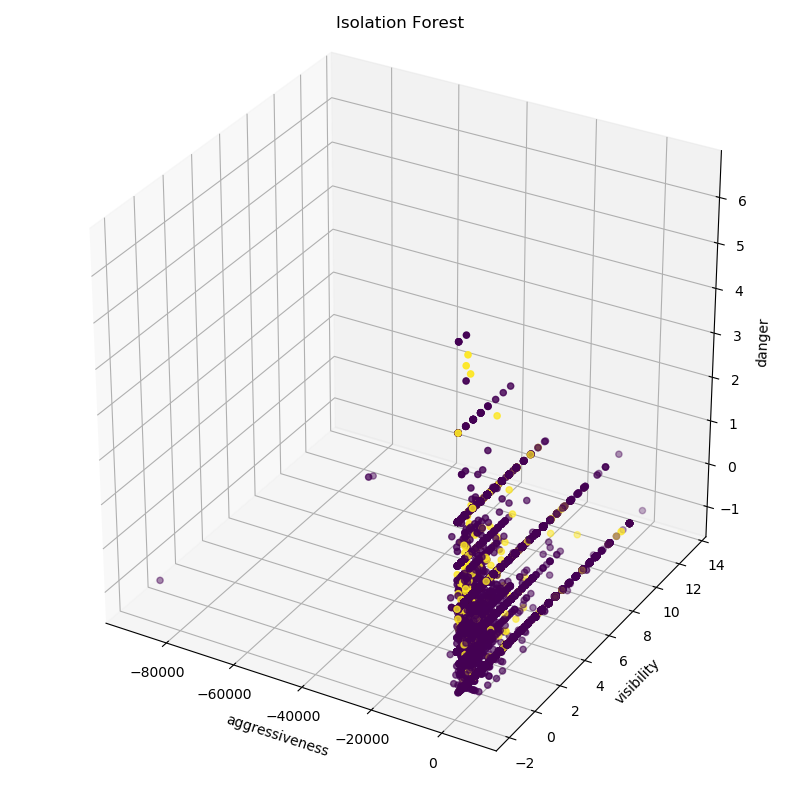

In [46]:
IsF = IsolationForest(contamination=0.01).fit_predict(scaled_df)*-1

plot3d(scaled_df,"Isolation Forest",labels=IsF)

### Local Outlier Factor

C:\Users\valer\Anaconda3\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


<IPython.core.display.Javascript object>


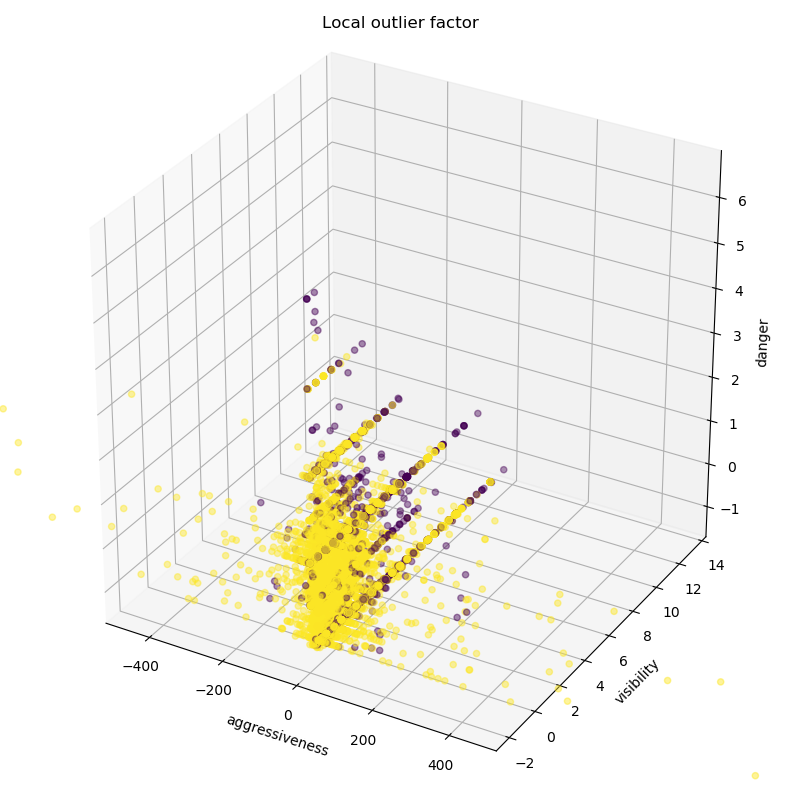

In [51]:
LoF = LocalOutlierFactor().fit_predict(scaled_df)

plot3d(scaled_df,"Local outlier factor",labels=LoF)

## Troisième étape : algorithme supervisé

In [53]:
LoF = LocalOutlierFactor().fit_predict(scaled_df)



C:\Users\valer\Anaconda3\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)



SVM:


C:\Users\valer\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


NameError: name 'df_pca' is not defined

In [54]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, LoF, test_size=0.30)

svm = SVC(random_state=42)
svm.fit(X_train,y_train)


C:\Users\valer\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

<IPython.core.display.Javascript object>


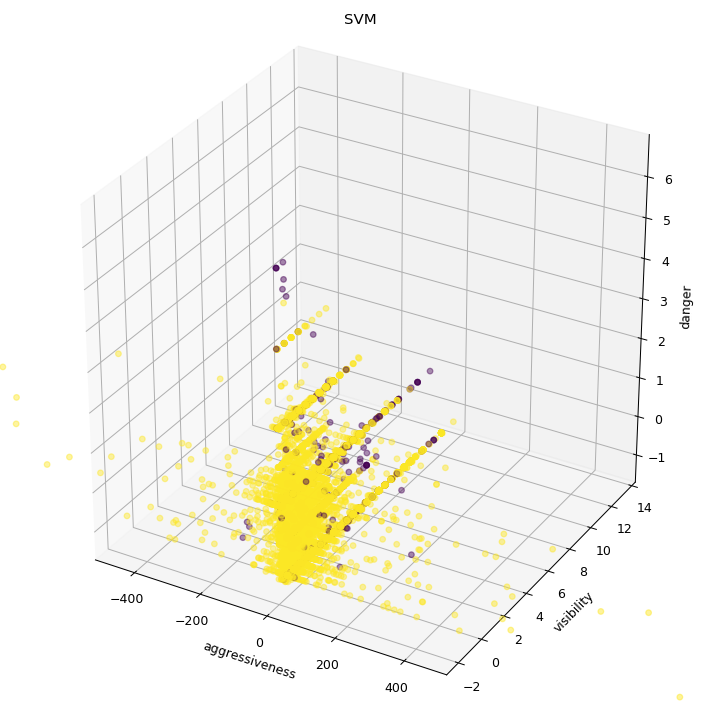

In [56]:
prd = svm.predict(X_test)
prd2 = svm.predict(scaled_df)
plot3d(scaled_df,"SVM",labels=prd2)